In [28]:
import torch.nn as nn
from model import  Resnet50FPN,Wide_Resnet50_2,VGG16FPN,CountRegressor,weights_normal_init
from utils_ltce import MAPS, Scales, Transform,TransformTrain,extract_features, visualize_output_and_save
from PIL import Image
import os
import torch
import argparse
import json
import numpy as np
from tqdm import tqdm
from os.path import exists,join
import random
import torch.optim as optim
import torch.nn.functional as F
import cv2
%matplotlib inline
import matplotlib.pyplot as plt
from collections import defaultdict
import torchvision.ops.boxes as bops

In [29]:
data_path = '/Users/alessandroquattrociocchi/Git/AML/Final_Project/data/'
output_dir = "./logsSave"
test_split = "val" #choices=["train", "test", "val"]
gpu = 0 
learning_rate = 1e-5
data_path = data_path
anno_file = data_path + 'annotation_FSC147_384.json'
data_split_file = data_path + 'Train_Test_Val_FSC_147.json'
im_dir = data_path + 'images_384_VarV2'
gt_dir = data_path + 'gt_density_map_adaptive_384_VarV2'
pre_trained_backbone = 'resnet' #choices=[resnet,wide_resnet,vgg16]

In [30]:
## YOLO 
import cv2
from collections import defaultdict
model = torch.hub.load('ultralytics/yolov5', 'yolov5s', pretrained=True) 


def YOLO_objects_count(image_path):

    detections = model(image_path)
    frame = cv2.imread(image_path)

    #frame = cv2.imread(image_path)
    #detections = model(frame[..., ::-1])
    results = detections.pandas().xyxy[0].to_dict(orient="records")
    for result in results:
        con = result['confidence']
        cs = result['class']
        x1 = int(result['xmin'])
        y1 = int(result['ymin'])
        x2 = int(result['xmax'])
        y2 = int(result['ymax'])
        return results


def count_class(results):

    dict_ = defaultdict(int)
    for i in results:
        dict_[i['name']] += 1
    num = max(dict_.values())

    return num



Using cache found in /Users/alessandroquattrociocchi/.cache/torch/hub/ultralytics_yolov5_master
YOLOv5 🚀 2021-12-8 torch 1.10.0 CPU

Fusing layers... 
Model Summary: 213 layers, 7225885 parameters, 0 gradients
Adding AutoShape... 


In [31]:
if pre_trained_backbone == 'vgg16':
    backbone = VGG16FPN()
elif pre_trained_backbone == 'resnet':
    backbone = Resnet50FPN()
elif pre_trained_backbone == 'wide_resnet':
    backbone = Wide_Resnet50_2()

In [32]:
if not exists(output_dir):
    os.mkdir(output_dir)

#setting id for each GPUs 
os.environ["CUDA_DEVICE_ORDER"] = "PCI_BUS_ID"
os.environ["CUDA_VISIBLE_DEVICES"] = str(gpu)

if not exists(output_dir):
    os.mkdir(output_dir)

os.environ["CUDA_DEVICE_ORDER"] = "PCI_BUS_ID"
os.environ["CUDA_VISIBLE_DEVICES"] = str(gpu)

#criterion = nn.MSELoss().cuda()
criterion = nn.MSELoss()

#backbone.cuda()
#backbone.eval()

regressor = CountRegressor(6, pool='mean')
weights_normal_init(regressor, dev=0.001)
regressor.train()
#regressor.cuda()
optimizer = optim.Adam(regressor.parameters(), lr = learning_rate)

with open(anno_file) as f:
    annotations = json.load(f)

with open(data_split_file) as f:
    data_split = json.load(f)


In [33]:
from collections import Counter

model_yolo = torch.hub.load('ultralytics/yolov5', 'yolov5l6', pretrained=True)

def count_class(results):

    dict_ = defaultdict(int)
    for i in results:
        dict_[i['name']] += 1
    num = max(dict_.values())

    return num


def most_frequent(List):
    occurence_count = Counter(List)
    return occurence_count.most_common(1)[0][0]

def intersects(box1, box2):

    box1 = torch.tensor([box1], dtype=torch.float)
    box2 = torch.tensor([box2], dtype=torch.float)
    iou = bops.box_iou(box1, box2).numpy()[0][0]
    return iou


Using cache found in /Users/alessandroquattrociocchi/.cache/torch/hub/ultralytics_yolov5_master
YOLOv5 🚀 2021-12-8 torch 1.10.0 CPU

Fusing layers... 
Model Summary: 476 layers, 76726332 parameters, 0 gradients
Adding AutoShape... 


In [34]:

def YOLO_boxes(results_yolo, annotations, threshold=4):
    """
    E.g. annotations = annotations['6.jpg']['box_examples_coordinates']
    This function takes as input the results of YOLO and returns a set of boxes which will then be used for the
    feature extraction part. In order to do this we will review a few things:
    1. Yolo needs to detect at least 3 or more objects. If less than this number of objects has been detected we remove this observation
    2. We keep only information regarding the most common object (which is typically the object we are trying to identify)
    3. We remove the boxes that are overlapping (we don't want to provide FamNet with two similar boxes)
    4. Keep only the boxes that are over a certain threshold level
        a. if threshold is int take top threshold
        b. if threshold is float take values above threshold
    5. We provide as output the boxes that fulfill all of the previous requirements
    """

    # Remove all classes that don't belong to the most common class
    list_ = []
    for i in results_yolo:
        list_.append(i['name'])
    
    name = most_frequent(list_)
    final_dict = [i for i in results_yolo if i['name'] == name]

    # More than 3 objects detected by YOLO
    if len(final_dict) < 3:
        return None

    # Check for overlaps 
    non_overlap = list(range(1, len(results_yolo)+1))
    overlap = []
    for example_box in annotations:
        list_original = [example_box[0][0], example_box[0][1], 
                        example_box[2][0], example_box[2][1]]
        for i, yolo_res in enumerate(results_yolo):
            list_yolo = [yolo_res['xmin'], yolo_res['ymin'],
                        yolo_res['xmax'], yolo_res['ymax']]
            if intersects(list_yolo, list_original) <= 0.10:
                overlap.append(i+1) 

    non_overlap = list(set(non_overlap).difference(set(overlap)))
    results_yolo = [results_yolo[i-1] for i in non_overlap]

    # Keep only the most probable boxes
    list_ = []
    for i in results_yolo:
        list_.append(i['confidence'])
    order = list(np.argsort(list_)[::-1])
    if isinstance(threshold, int):
        results_yolo = [results_yolo[i] for i in order[:threshold]]
    elif isinstance(threshold, float):
        order_float = list(np.sort(list_)[::-1])
        pos = len([i for i in order_float if i >= threshold])
        results_yolo = [results_yolo[i] for i in order[:pos]]

    # Return boxes as in the annotation file
    final_list = []
    for i in results_yolo:
        final_list.append([i['xmin'], i['ymin'], i['xmax'], i['ymax']])

    return final_list

In [8]:
import warnings
warnings.filterwarnings("ignore")

In [39]:
%matplotlib inline

def train(data=data_split['train'],pre_trained_backbone='resnet', yolo_flag = True,yolo_threshold = 3,n_img =1,shuffle_flag=True,plot_flag=False, im_dir=im_dir, annotations=annotations, best_mae=1e7, best_rmse=1e7):

    print("Training on FSC147 train set data")
    im_ids = data[:n_img]
    if shuffle_flag:
        random.shuffle(im_ids)
    train_mae = 0
    train_rmse = 0
    train_loss = 0
    pbar = tqdm(im_ids)
    cnt = 0
    for im_id in pbar:
        cnt += 1
        anno = annotations[im_id]
        bboxes = anno['box_examples_coordinates']
        dots = np.array(anno['points'])

        image_path = '{}/{}'.format(im_dir, im_id)
        image = Image.open('{}/{}'.format(im_dir, im_id))
        image.load()
        if plot_flag:
            plt.imshow(image)
            plt.show()
            plt.close()
        density_path = gt_dir + '/' + im_id.split(".jpg")[0] + ".npy"
        density = np.load(density_path).astype('float32')   

        rects = list()

        for bbox in bboxes:
            x1 = bbox[0][0]
            y1 = bbox[0][1]
            x2 = bbox[2][0]
            y2 = bbox[2][1]
            rects.append([y1, x1, y2, x2]) 

        if yolo_flag:
            detections = model_yolo(image_path)
            results_yolo = detections.pandas().xyxy[0].to_dict(orient="records")

            try:
                yolo_obj_cnt = count_class(results_yolo)
            except:
                yolo_obj_cnt = 0

            for result in results_yolo:
                con = result['confidence']
                cs = result['class']
                x1 = int(result['xmin'])
                y1 = int(result['ymin'])
                x2 = int(result['xmax'])
                y2 = int(result['ymax'])

            yolo_res = YOLO_boxes(results_yolo, bboxes, threshold=yolo_threshold)

            frame_1 = cv2.imread(image_path)
            frame_1 = cv2.cvtColor(frame_1, cv2.COLOR_BGR2RGB)
            
            frame_2 = cv2.imread(image_path)
            frame_2 = cv2.cvtColor(frame_2, cv2.COLOR_BGR2RGB)

            for i in bboxes:
                x1 = i[0][0]
                y1 = i[0][1]
                x2 = i[2][0]
                y2 = i[2][1]
                # Do whatever you want
                f1 = cv2.rectangle(frame_1, (x1, y1), (x2, y2),color=(255,0,0),thickness=3)
            
            if plot_flag:
                plt.imshow(f1)
                plt.show()
                plt.close()

            print('')
            print('YOLO:', yolo_res)
            if yolo_res:
                print('Updating rects')
                for i in yolo_res:
                    x1 = int(i[0])
                    y1 = int(i[1])
                    x2 = int(i[2])
                    y2 = int(i[3])
                    # Do whatever you want
                    f2 = cv2.rectangle(frame_2, (x1, y1), (x2, y2),color=(0,255,0),thickness=3)
            
                if plot_flag:
                    plt.imshow(f2)
                    plt.show()
                    plt.close()

            if yolo_res:
                print('Updating rects')
                rects += yolo_res


        sample = {'image':image,'lines_boxes':rects,'gt_density':density}
        sample = TransformTrain(sample)
        #image, boxes,gt_density = sample['image'].cuda(), sample['boxes'].cuda(),sample['gt_density'].cuda()
        image, boxes,gt_density = sample['image'], sample['boxes'],sample['gt_density']
            
        if pre_trained_backbone == 'vgg16':
            backbone = VGG16FPN()
        elif pre_trained_backbone == 'resnet':
            backbone = Resnet50FPN()
        elif pre_trained_backbone == 'wide_resnet':
            backbone = Wide_Resnet50_2()

        with torch.no_grad():
            features = extract_features(backbone, image.unsqueeze(0), boxes.unsqueeze(0), MAPS, Scales)
        features.requires_grad = True
        optimizer.zero_grad()
        output = regressor(features)

        #if image size isn't divisible by 8, gt size is slightly different from output size
        if output.shape[2] != gt_density.shape[2] or output.shape[3] != gt_density.shape[3]:
            orig_count = gt_density.sum().detach().item()
            gt_density = F.interpolate(gt_density, size=(output.shape[2],output.shape[3]),mode='bilinear')
            new_count = gt_density.sum().detach().item()
            if new_count > 0: gt_density = gt_density * (orig_count / new_count)
        loss = criterion(output, gt_density)
        loss.backward()
        optimizer.step()
        train_loss += loss.item()
        pred_cnt = torch.sum(output).item()
        gt_cnt = torch.sum(gt_density).item()
        cnt_err = abs(pred_cnt - gt_cnt)
        train_mae += cnt_err
        train_rmse += cnt_err ** 2

        pbar.set_description('actual:{:6.1f} -- predicted:{:6.1f} -- YOLO:{:6.1f} -- FAMNet error:{:6.1f} -- YOLO error:{:6.1f} -- Current MAE:{:5.2f} -- RMSE:{:5.2f} -- Best VAL MAE:{:5.2f} -- RMSE: {:5.2f}'.format( gt_cnt, pred_cnt, yolo_obj_cnt,abs(pred_cnt - gt_cnt),abs(yolo_obj_cnt - gt_cnt), train_mae/cnt, (train_rmse/cnt)**0.5,best_mae,best_rmse))
        print("")
    train_loss = train_loss / len(im_ids)
    train_mae = (train_mae / len(im_ids))
    train_rmse = (train_rmse / len(im_ids))**0.5
    return train_loss,train_mae,train_rmse


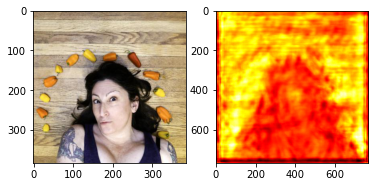

In [94]:
fig,(ax1,ax2) = plt.subplots(1,2)
ax1.imshow(image)
ax2.imshow(density_matrix, cmap='hot', interpolation='nearest')

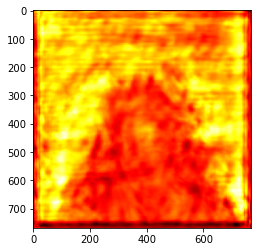

In [92]:
density_matrix = output[0][0].detach().cpu().numpy()
plt.imshow(density_matrix, cmap='hot', interpolation='nearest')

In [36]:
def eval(data=data_split[test_split], backbone='resnet', yolo_flag=True, yolo_threshold=3, n_img=1, plot_flag=False, im_dir=im_dir, annotations=annotations):
    cnt = 0
    SAE = 0 # sum of absolute errors
    SSE = 0 # sum of square errors

    print("Evaluation on {} data".format(test_split))
    im_ids = data[:n_img]
    pbar = tqdm(im_ids)
    for im_id in pbar:
        anno = annotations[im_id]
        bboxes = anno['box_examples_coordinates']
        dots = np.array(anno['points'])
        image_path = '{}/{}'.format(im_dir, im_id)

        rects = list()
        for bbox in bboxes:
            x1 = bbox[0][0]
            y1 = bbox[0][1]
            x2 = bbox[2][0]
            y2 = bbox[2][1]
            rects.append([y1, x1, y2, x2])
        
        if yolo_flag:
                
            detections = model_yolo(image_path)
            results_yolo = detections.pandas().xyxy[0].to_dict(orient="records")

            try:
                yolo_obj_cnt = count_class(results_yolo)
            except:
                yolo_obj_cnt = 0

            for result in results_yolo:
                con = result['confidence']
                cs = result['class']
                x1 = int(result['xmin'])
                y1 = int(result['ymin'])
                x2 = int(result['xmax'])
                y2 = int(result['ymax'])

            yolo_res = YOLO_boxes(results_yolo, bboxes, threshold=yolo_threshold)

            frame_1 = cv2.imread(image_path)
            frame_1 = cv2.cvtColor(frame_1, cv2.COLOR_BGR2RGB)
            
            frame_2 = cv2.imread(image_path)
            frame_2 = cv2.cvtColor(frame_2, cv2.COLOR_BGR2RGB)

            for i in bboxes:
                x1 = i[0][0]
                y1 = i[0][1]
                x2 = i[2][0]
                y2 = i[2][1]
                # Do whatever you want
                f1 = cv2.rectangle(frame_1, (x1, y1), (x2, y2),color=(255,0,0),thickness=3)
            
            if plot_flag:
                plt.imshow(f1)
                plt.show()
                plt.close()

            print('')

            if yolo_res:
                for i in yolo_res:
                    x1 = int(i[0])
                    y1 = int(i[1])
                    x2 = int(i[2])
                    y2 = int(i[3])
                    # Do whatever you want
                    f2 = cv2.rectangle(frame_2, (x1, y1), (x2, y2),color=(0,255,0),thickness=3)
            
                if plot_flag:
                    plt.imshow(f2)
                    plt.show()
                    plt.close()

            if yolo_res:
                rects += yolo_res

        image = Image.open('{}/{}'.format(im_dir, im_id))
        image.load()
        sample = {'image':image,'lines_boxes':rects}
        sample = Transform(sample)
        sample['image'].shape
        #image, boxes = sample['image'].cuda(), sample['boxes'].cuda()
        image, boxes = sample['image'], sample['boxes']

        if pre_trained_backbone == 'vgg16':
            backbone = VGG16FPN()
        elif pre_trained_backbone == 'resnet':
            backbone = Resnet50FPN()
        elif pre_trained_backbone == 'wide_resnet':
            backbone = Wide_Resnet50_2()

        with torch.no_grad():
            output = regressor(extract_features(backbone, image.unsqueeze(0), boxes.unsqueeze(0), MAPS, Scales))

        gt_cnt = dots.shape[0]
        pred_cnt = output.sum().item()
        cnt = cnt + 1
        err = abs(gt_cnt - pred_cnt)
        SAE += err
        SSE += err**2

        pbar.set_description('{:<8}: actual-predicted: {:6d}, {:6.1f}, error: {:6.1f}. Current MAE: {:5.2f}, RMSE: {:5.2f}, YOLO: {:6.1f}'.format(im_id, gt_cnt, pred_cnt, abs(pred_cnt - gt_cnt), SAE/cnt, (SSE/cnt)**0.5, yolo_obj_cnt))
        print("")

    print('On {} data, MAE: {:6.2f}, RMSE: {:6.2f}'.format(test_split, SAE/cnt, (SSE/cnt)**0.5))
    return SAE/cnt, (SSE/cnt)**0.5

In [40]:
def run_train_phase(epochs, pre_trained_backbone, data_train, shuffle, data_val, num_img_train, num_img_val, yolo_flag, yolo_threshold, plot_flag, save='model.pth', im_dir=im_dir):

    best_mae, best_rmse = 1e7, 1e7
    stats = list()
    for epoch in range(0,epochs):
        regressor.train()
        train_loss,train_mae,train_rmse = train(data=data_train, pre_trained_backbone=pre_trained_backbone, yolo_flag = yolo_flag, 
                                                yolo_threshold = yolo_threshold,n_img = num_img_train,
                                                shuffle_flag=shuffle,plot_flag=plot_flag, im_dir=im_dir, best_mae=best_mae, best_rmse=best_rmse)
        regressor.eval()
        val_mae,val_rmse = eval(data=data_val, backbone=pre_trained_backbone, yolo_flag=yolo_flag, yolo_threshold=yolo_threshold, 
                                n_img=num_img_val, plot_flag=plot_flag, im_dir=im_dir)
        stats.append((train_loss, train_mae, train_rmse, val_mae, val_rmse))
        stats_file = join("stats" +  ".txt")
        with open(stats_file, 'w') as f:
            for s in stats:
                f.write("%s\n" % ','.join([str(x) for x in s]))    
        if best_mae >= val_mae:
            best_mae = val_mae
            best_rmse = val_rmse
            if save:
                torch.save(regressor.state_dict(), save)

        print("Epoch {}, Avg. Epoch Loss: {} Train MAE: {} Train RMSE: {} Val MAE: {} Val RMSE: {} Best Val MAE: {} Best Val RMSE: {} ".format(
                epoch+1,  stats[-1][0], stats[-1][1], stats[-1][2], stats[-1][3], stats[-1][4], best_mae, best_rmse))

Training on FSC147 train set data


  0%|          | 0/5 [00:00<?, ?it/s]

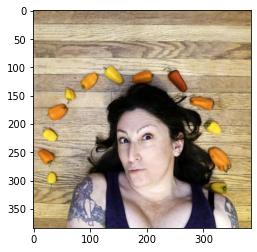

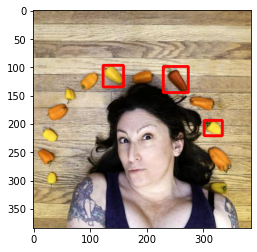


YOLO: []


actual:  13.0 -- predicted:   1.7 -- YOLO:   6.0 -- FAMNet error:  11.3 -- YOLO error:   7.0 -- Current MAE:11.32 -- RMSE:11.32 -- Best VAL MAE:10000000.00 -- RMSE: 10000000.00:  20%|██        | 1/5 [00:08<00:33,  8.39s/it]

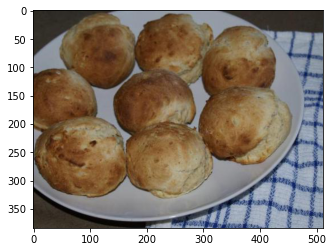

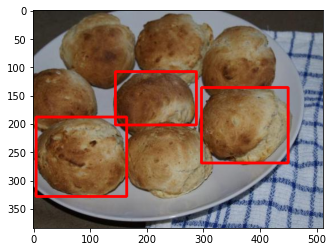


YOLO: []


actual:   8.0 -- predicted:   2.9 -- YOLO:   7.0 -- FAMNet error:   5.1 -- YOLO error:   1.0 -- Current MAE: 8.20 -- RMSE: 8.78 -- Best VAL MAE:10000000.00 -- RMSE: 10000000.00:  40%|████      | 2/5 [00:17<00:25,  8.62s/it]

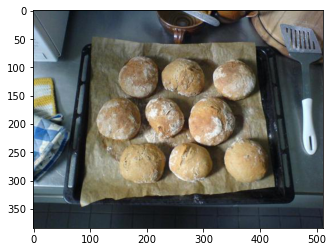

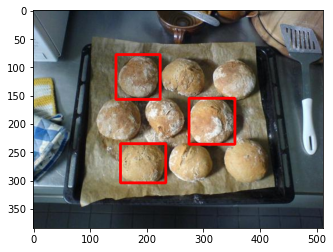


YOLO: None


actual:   9.0 -- predicted:   3.2 -- YOLO:   2.0 -- FAMNet error:   5.8 -- YOLO error:   7.0 -- Current MAE: 7.39 -- RMSE: 7.90 -- Best VAL MAE:10000000.00 -- RMSE: 10000000.00:  60%|██████    | 3/5 [00:25<00:17,  8.68s/it]

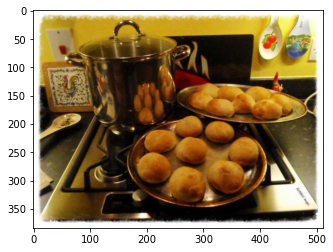

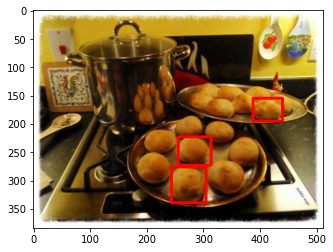


YOLO: []


actual:  16.0 -- predicted:   3.7 -- YOLO:  10.0 -- FAMNet error:  12.3 -- YOLO error:   6.0 -- Current MAE: 8.61 -- RMSE: 9.19 -- Best VAL MAE:10000000.00 -- RMSE: 10000000.00:  80%|████████  | 4/5 [00:34<00:08,  8.72s/it]

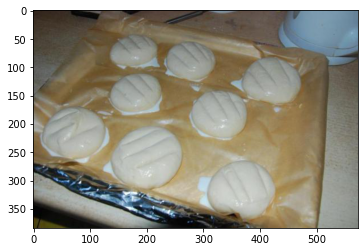

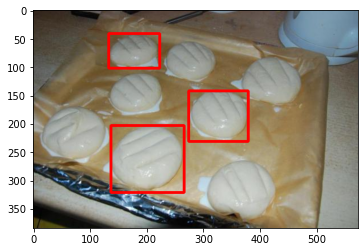


YOLO: None


actual:   8.0 -- predicted:   4.6 -- YOLO:   1.0 -- FAMNet error:   3.4 -- YOLO error:   7.0 -- Current MAE: 7.57 -- RMSE: 8.36 -- Best VAL MAE:10000000.00 -- RMSE: 10000000.00: 100%|██████████| 5/5 [00:43<00:00,  8.74s/it]



Evaluation on val data


  0%|          | 0/5 [00:00<?, ?it/s]

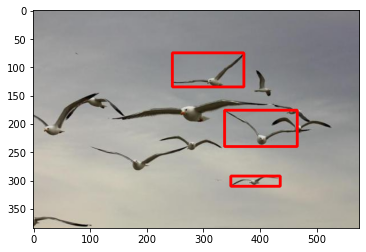

190.jpg : actual-predicted:     13,   82.1, error:   69.1. Current MAE: 69.07, RMSE: 69.07, YOLO:   10.0:  20%|██        | 1/5 [00:17<01:10, 17.50s/it]

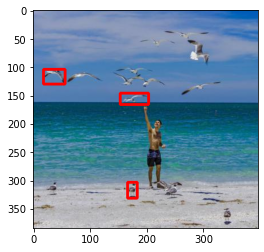

191.jpg : actual-predicted:     15,   56.6, error:   41.6. Current MAE: 55.36, RMSE: 57.03, YOLO:   15.0:  40%|████      | 2/5 [00:31<00:46, 15.48s/it]

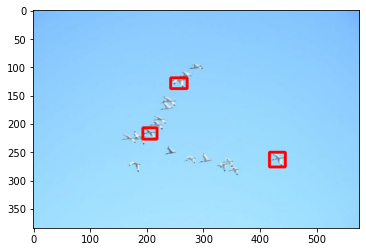

192.jpg : actual-predicted:     19,   80.3, error:   61.3. Current MAE: 57.35, RMSE: 58.50, YOLO:   10.0:  60%|██████    | 3/5 [00:48<00:32, 16.33s/it]

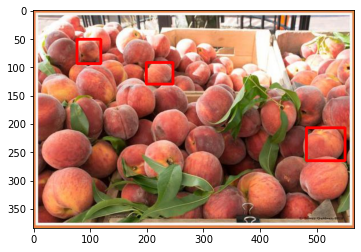

194.jpg : actual-predicted:     82,   91.9, error:    9.9. Current MAE: 45.48, RMSE: 50.90, YOLO:    3.0:  80%|████████  | 4/5 [01:06<00:16, 16.77s/it]

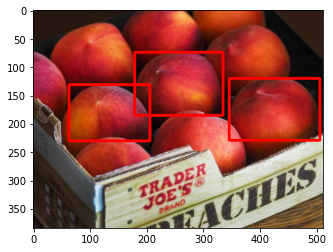

195.jpg : actual-predicted:     10,   78.2, error:   68.2. Current MAE: 50.03, RMSE: 54.81, YOLO:    1.0: 100%|██████████| 5/5 [01:23<00:00, 16.69s/it]



On val data, MAE:  50.03, RMSE:  54.81
Epoch 1, Avg. Epoch Loss: 1.75106395658986e-06 Train MAE: 7.565496230125428 Train RMSE: 8.35960140499668 Val MAE: 50.03145141601563 Val RMSE: 54.81219493978708 Best Val MAE: 50.03145141601563 Best Val RMSE: 54.81219493978708 
Training on FSC147 train set data


  0%|          | 0/5 [00:00<?, ?it/s]

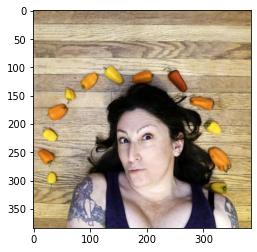

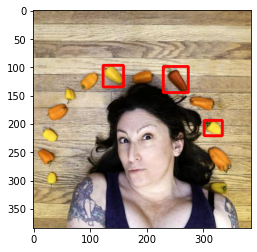


YOLO: []


actual:  13.0 -- predicted:   3.4 -- YOLO:   6.0 -- FAMNet error:   9.6 -- YOLO error:   7.0 -- Current MAE: 9.60 -- RMSE: 9.60 -- Best VAL MAE:50.03 -- RMSE: 54.81:  20%|██        | 1/5 [00:08<00:32,  8.22s/it]

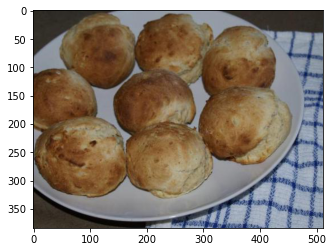

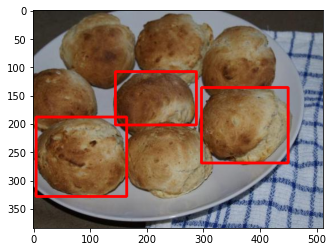


YOLO: []


actual:   8.0 -- predicted:   5.5 -- YOLO:   7.0 -- FAMNet error:   2.5 -- YOLO error:   1.0 -- Current MAE: 6.06 -- RMSE: 7.02 -- Best VAL MAE:50.03 -- RMSE: 54.81:  40%|████      | 2/5 [00:16<00:25,  8.47s/it]

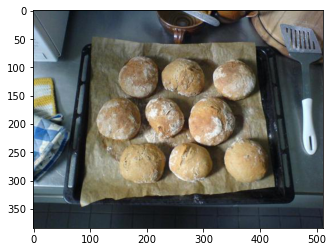

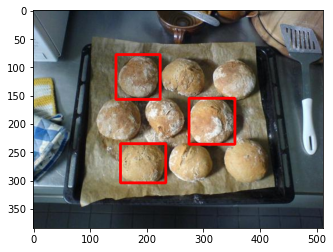


YOLO: None


actual:   9.0 -- predicted:   5.6 -- YOLO:   2.0 -- FAMNet error:   3.4 -- YOLO error:   7.0 -- Current MAE: 5.17 -- RMSE: 6.06 -- Best VAL MAE:50.03 -- RMSE: 54.81:  60%|██████    | 3/5 [00:25<00:17,  8.54s/it]

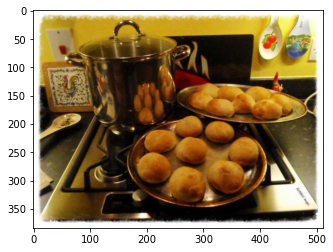

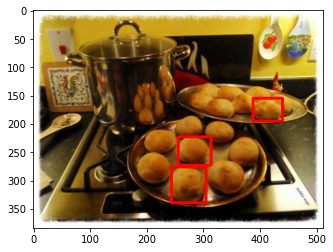


YOLO: []


actual:  16.0 -- predicted:   6.1 -- YOLO:  10.0 -- FAMNet error:   9.9 -- YOLO error:   6.0 -- Current MAE: 6.35 -- RMSE: 7.21 -- Best VAL MAE:50.03 -- RMSE: 54.81:  80%|████████  | 4/5 [00:34<00:08,  8.55s/it]

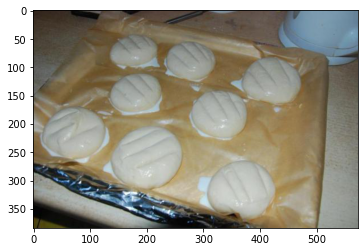

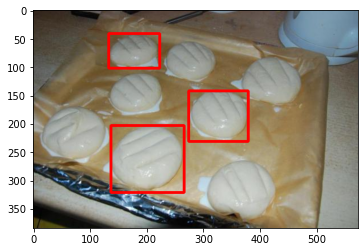


YOLO: None


actual:   8.0 -- predicted:   7.2 -- YOLO:   1.0 -- FAMNet error:   0.8 -- YOLO error:   7.0 -- Current MAE: 5.24 -- RMSE: 6.46 -- Best VAL MAE:50.03 -- RMSE: 54.81: 100%|██████████| 5/5 [00:42<00:00,  8.58s/it]



Evaluation on val data


  0%|          | 0/5 [00:00<?, ?it/s]

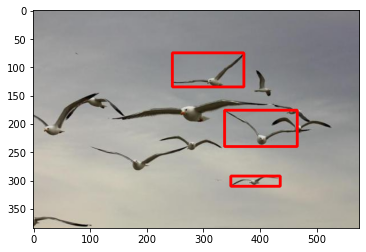

190.jpg : actual-predicted:     13,  122.4, error:  109.4. Current MAE: 109.38, RMSE: 109.38, YOLO:   10.0:  20%|██        | 1/5 [00:17<01:09, 17.40s/it]

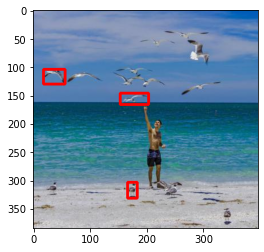

191.jpg : actual-predicted:     15,   84.7, error:   69.7. Current MAE: 89.55, RMSE: 91.72, YOLO:   15.0:  40%|████      | 2/5 [00:31<00:46, 15.57s/it]  

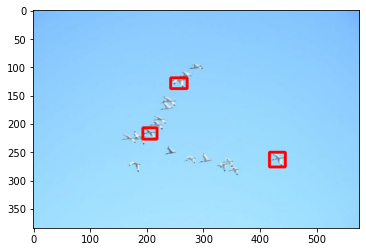

192.jpg : actual-predicted:     19,  119.2, error:  100.2. Current MAE: 93.10, RMSE: 94.63, YOLO:   10.0:  60%|██████    | 3/5 [00:49<00:33, 16.72s/it]

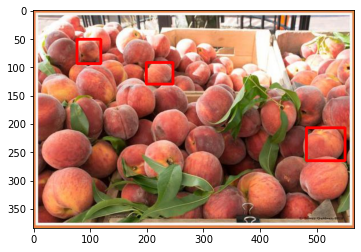

In [41]:
run_train_phase(3, pre_trained_backbone='vgg16', data_train=data_split['train'], shuffle=False, data_val=data_split['val'], 
                num_img_train=5, num_img_val=5, yolo_flag=True, yolo_threshold=3, plot_flag=True, save=False, im_dir=im_dir)

'./logsSave'

In [14]:
from captum.attr import IntegratedGradients
from captum.attr import GradientShap
from captum.attr import Occlusion
from captum.attr import NoiseTunnel
from captum.attr import visualization as viz

In [16]:
import torch
import torch.nn.functional as F

from PIL import Image

import os
import json
import numpy as np
from matplotlib.colors import LinearSegmentedColormap

import torchvision
from torchvision import models
from torchvision import transforms

from captum.attr import IntegratedGradients
from captum.attr import GradientShap
from captum.attr import Occlusion
from captum.attr import NoiseTunnel
from captum.attr import visualization as viz

In [26]:
img = Image.open(image_path)

transform = transforms.Compose([
 transforms.Resize(256),
 transforms.CenterCrop(224),
 transforms.ToTensor()
])

transform_normalize = transforms.Normalize(
     mean=[0.485, 0.456, 0.406],
     std=[0.229, 0.224, 0.225]
 )

transformed_img = transform(img)
input = transform_normalize(transformed_img)
input = input.unsqueeze(0)


In [27]:
from torchvision import models
model = models.resnet50(pretrained=True)
model = model.eval()

output = model(input)
output= F.softmax(output,dim=1)
prediction_score, pred_label_idx = torch.topk(output, 1)
pred_label_idx.squeeze_()



integrated_gradients = IntegratedGradients(model)
attributions_ig = integrated_gradients.attribute(input, target=pred_label_idx, n_steps=1)

tensor(641)

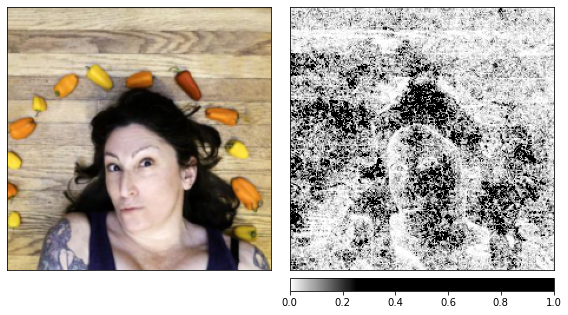

In [31]:
torch.manual_seed(0)
np.random.seed(0)

default_cmap = LinearSegmentedColormap.from_list('custom blue', 
                                                 [(0, '#ffffff'),
                                                  (0.25, '#000000'),
                                                  (1, '#000000')], N=256)


gradient_shap = GradientShap(model)

# Defining baseline distribution of images
rand_img_dist = torch.cat([input * 0, input * 1])

attributions_gs = gradient_shap.attribute(input,
                                          n_samples=50,
                                          stdevs=0.0001,
                                          baselines=rand_img_dist,
                                          target=pred_label_idx)
_ = viz.visualize_image_attr_multiple(np.transpose(attributions_gs.squeeze().cpu().detach().numpy(), (1,2,0)),
                                      np.transpose(transformed_img.squeeze().cpu().detach().numpy(), (1,2,0)),
                                      ["original_image", "heat_map"],
                                      ["all", "absolute_value"],
                                      cmap=default_cmap,
                                      show_colorbar=True)